<a href="https://colab.research.google.com/github/JulianSKYOO/MATH3041/blob/main/RNN_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 !pip install yfinance
 !pip install sktime
 !pip install darts

import numpy as np

# To build our crypto prediction model we will use tensorflow (explanation coiming later)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout

from darts.timeseries import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel, ExponentialSmoothing

from sklearn.preprocessing import StandardScaler
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import yfinance as yf
import keras
import tensorflow as tf

%config InlineBackend.figure_format = 'svg'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.7 MB/s 
     |████████████████████████████████| 6.4 MB 58.7 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.28.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |██████████

TypeError: ignored

In [ ]:
df = yf.download('BTC-AUD')
df.head()

NameError: ignored

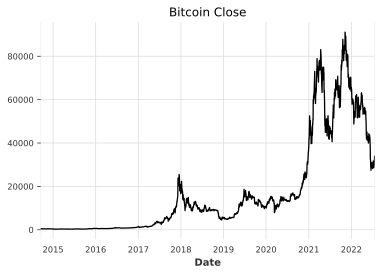

In [ ]:
df['Close'].plot(title='Bitcoin Close')

Observing the following syntax, we are able to plot particular points in time with ease. This was done very easily since the date was the index column of the dataframe

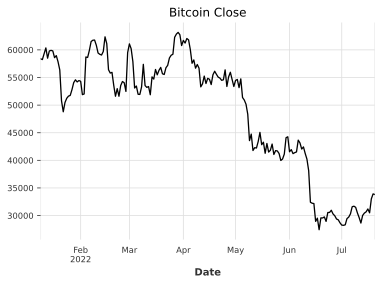

In [ ]:
df.loc['January 9 2022':, 'Close'].plot(title='Bitcoin Close');

## Split data

We can't split the data randomly since we need to maintain continuity.

This means that instead of drawing random samples from the data set to create the train and test set, we withhold a certain amount of data to act as the train set.

**See the diagram below for an example**

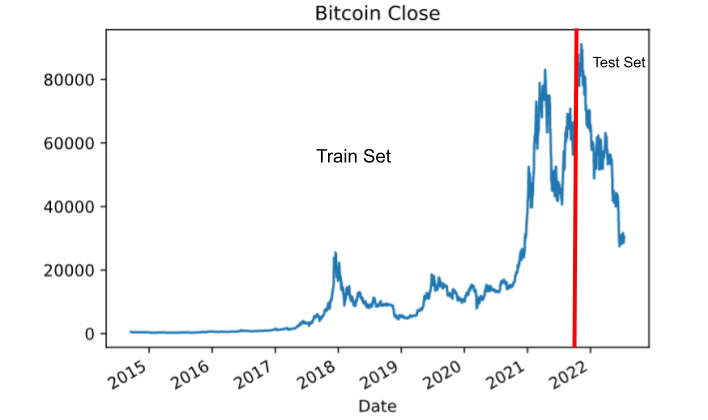

In [ ]:
df.reset_index()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,513.122620,516.007935,504.935272,510.645386,510.645386,23511389
1,2014-09-18,510.116119,510.002228,459.924286,472.650330,472.650330,38400000
2,2014-09-19,472.275055,477.761017,428.161682,442.249359,442.249359,42477540
3,2014-09-20,442.111572,474.174957,436.745819,458.053101,458.053101,41294500
4,2014-09-21,457.135651,461.998413,440.440247,446.308197,446.308197,29744964
...,...,...,...,...,...,...,...
2859,2022-07-16,30667.072266,31666.771484,30203.101562,31189.750000,31189.750000,35771202137
2860,2022-07-17,31196.705078,31793.701172,30495.759766,30497.470703,30497.470703,33650722416
2861,2022-07-18,30501.238281,33112.785156,30501.238281,33019.605469,33019.605469,58701398077
2862,2022-07-19,32993.410156,34305.640625,31647.625000,33919.894531,33919.894531,70720418551


https://unit8co.github.io/darts/generated_api/darts.timeseries.html# read this!!!

In [ ]:
series = TimeSeries.from_dataframe(df.reset_index(), 'Date', 'Close')
series

                   Close
Date                    
2014-09-17    510.645386
2014-09-18    472.650330
2014-09-19    442.249359
2014-09-20    458.053101
2014-09-21    446.308197
...                  ...
2022-07-16  31189.750000
2022-07-17  30497.470703
2022-07-18  33019.605469
2022-07-19  33919.894531
2022-07-20  33805.773438

[2864 rows x 1 columns]
Freq: D

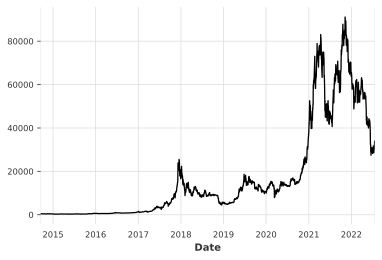

In [ ]:
# DARTS allows for plotting too
series.plot()

In [ ]:
# Create training and validation sets:
train, val = series.split_after(pd.Timestamp("January 1 2022"))

In [ ]:
# Normalize the time series (note: we avoid fitting the transformer on the validation set)
transformer = Scaler()
train_transformed = transformer.fit_transform(train)  # training set
val_transformed = transformer.transform(val)          # validation set
series_transformed = transformer.transform(series)    # full set

https://unit8.com/resources/training-forecasting-models/

In this code snippet, we create an `RNNModel` instance. The `input_chunk_length` and `output_chunk_length` parameters specify the lengths of the time series slices taken by the internal `RNN` in input and output.

In this case, the `RNN` will look 50 periods in the past and produce forecasts by outputting “chunks” of 25 points in the future.

In [ ]:
rnn_model = RNNModel(model="LSTM",
                     input_chunk_length=50,
                     output_chunk_length=25,
                     dropout=0,
                     batch_size=16,
                     optimizer_kwargs={"lr": 1e-3},
                     model_name="bitcoin_rnn",
                     n_epochs=25,
                     random_state=15)

rnn_model.fit(train_transformed, val_series=val_transformed)

[2022-07-20 05:03:51,602] INFO | darts.models.torch_forecasting_model | Train dataset contains 2590 samples.
[2022-07-20 05:03:51,602] INFO | darts.models.torch_forecasting_model | Train dataset contains 2590 samples.


Look into predictions on the validation set

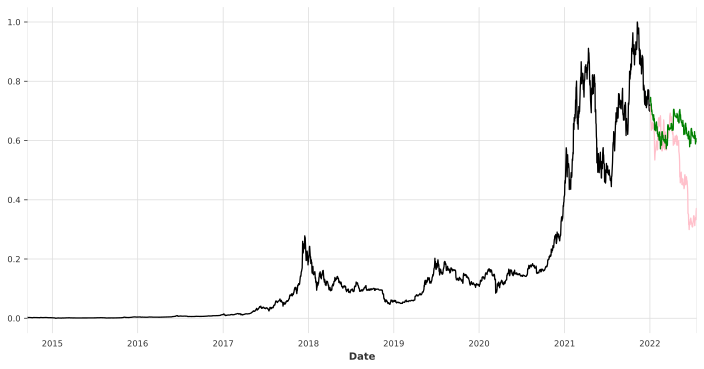

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
train_transformed.plot(ax=ax, color='black')
val_transformed.plot(ax=ax, color='pink')

yhat = rnn_model.predict(n=len(val_transformed), series=train_transformed)
yhat.plot(ax=ax, color='green')

In [ ]:
kigbfokev

NameError: ignored

In [ ]:
y = df['Close']

train, test = temporal_train_test_split(y, test_size=0.1)

In [ ]:
train.plot()

In [ ]:
test.plot()

In [ ]:
train = pd.DataFrame(train)
test = pd.DataFrame(test)

## Scaling Data

We scale the data to allow gradient descent to converge faster. Find out more [here](https://machinelearningmastery.com/how-to-improve-neural-network-stability-and-modeling-performance-with-data-scaling/)!

For those familiar with statistics, the standard scalar transformation will shift the data so that it has mean 0 and variance 1.

This is the formula: $$\frac{x - \mu}{\sigma}$$

In [ ]:
scaler = StandardScaler()

X_train = scaler.fit_transform(train)
X_test = scaler.transform(test)

In [ ]:
print(X_train.shape)
print(X_test.shape)

## Feature engineering (lags)

*A 'lag' is essentially a delay.*

For example, the 1 hour lag of 12pm is 11am.

In time series analysis, for lag 1, we compare the current time series with its past self exactly 1 time step in the past.

*See the diagram below for a more concrete example:*

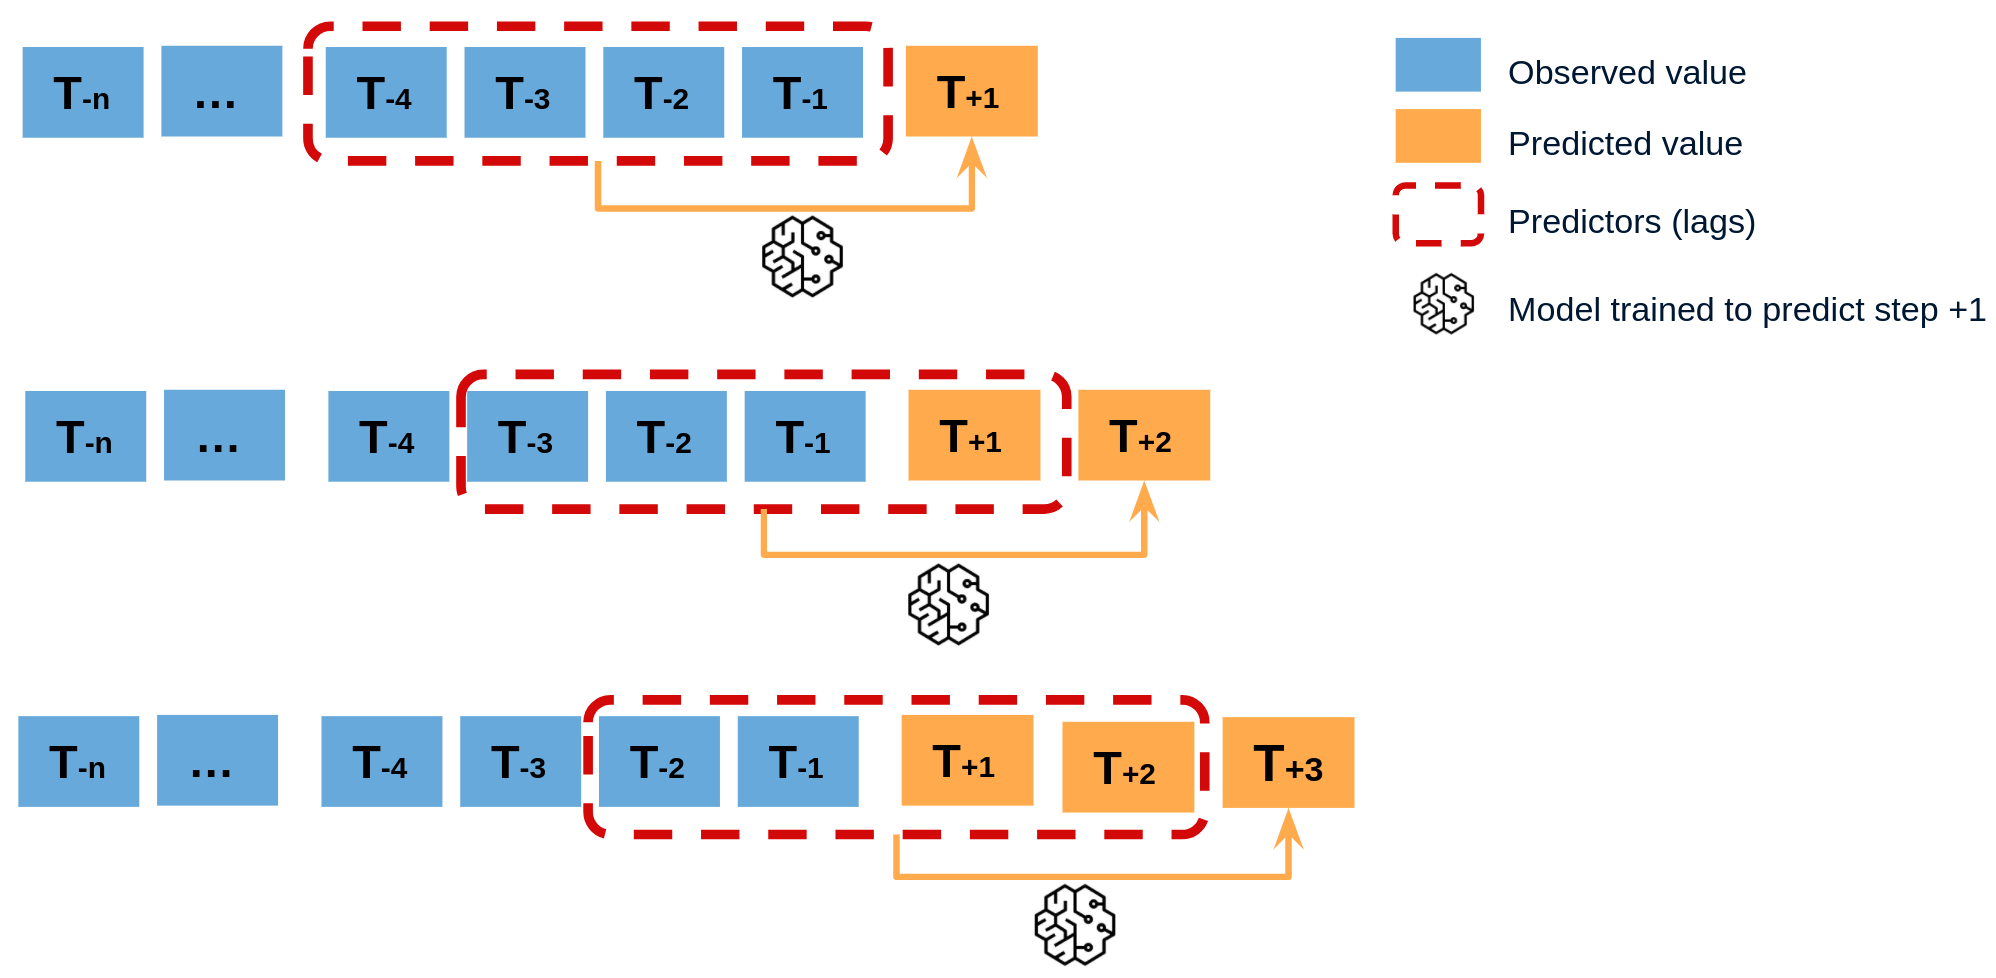
Source: https://www.cienciadedatos.net/documentos/py27-time-series-forecasting-python-scikitlearn.html

In [ ]:
def create_dataset(dataset, time_step=1):
    """Creates a dataset suteable for tensorflow time series modelling"""
    X = []
    y = []
    for i in range(len(dataset)-time_step-1):
        X.append(dataset[i:(i+time_step), 0] )
        y.append(dataset[i + time_step, 0])

    X = np.array(X)
    y = np.array(y)

    return X, y

In [ ]:
TIME_STEP = 10
X_train, y_train = create_dataset(dataset=X_train, time_step=TIME_STEP)
X_test, y_test = create_dataset(dataset=X_test, time_step=TIME_STEP)

In [ ]:
pd.DataFrame(X_train)

In [ ]:
y_train

In [ ]:
print(X_train.shape)
print(y_train.shape)

In [ ]:
# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] , 1)

In [ ]:
print(X_train.shape)

## Building the model

To build the model we're going to use the popular deep learning package, *Tensorflow*.

Tensorflow lets us specify from a high level the architecture of our network.

The architecture is as follows:

1. Our training data of size *(BATCH_SIZE, 10, 1)* to an LSTM layer which squashes the output to size *(BATCH_SIZE, 16)*
2. We pass the output of the LSTM layer to a fully connected (or dense) layer which squashes the output even more to a size of *(BATCH_SIZE, 1)*
3. The output from the dense layer is a vector of predictions i.e. our forecasted price!!

In [ ]:
import tensorflow as tf

tf.random.set_seed(1)

model = Sequential()

# Add LSTM Layer
model.add(LSTM(units=16, input_shape=(None, 1), activation='tanh', recurrent_activation='sigmoid'))

# Final layer with 1 neuron
model.add(Dense(units=1))

# Define L as mean squared error and minimise using the ADAM optimiser
model.compile(loss='mse', optimizer='adam')
model.summary()

In [ ]:
model.fit(X_train, y_train, batch_size=10, verbose=1, epochs=30, validation_data = (X_test, y_test))

In [ ]:
fig, (ax1, ax2) = plt.subplots(figsize=(12, 6), ncols=2)

sns.lineplot(x=model.history.epoch,
             y=model.history.history['loss'],
             color='black',
             label='training loss',
             ax=ax1)

sns.lineplot(x=model.history.epoch,
             y=model.history.history['val_loss'],
             color='green',
             label='val loss',
             ax=ax2)

## Let's make some predictions

1. First take a look at the Mean squared error (MSE), is it intuitive?
2. Take a look at the forecasts, are the results what you expected?

In [ ]:
# Get predictions back into unscaled values

yhat_train = scaler.inverse_transform(model.predict(X_train))
yhat_test = scaler.inverse_transform(model.predict(X_test))

In [ ]:
y_train = scaler.inverse_transform([y_train])
y_test = scaler.inverse_transform([y_test])

In [ ]:
# MSE
from sklearn.metrics import mean_squared_error as mse

print(f'Training MSE: {mse(y_true=y_train[0], y_pred=yhat_train[:, 0])}')
print(f'Test MSE: {mse(y_true=y_test[0], y_pred=yhat_test[:, 0])}')

In [ ]:
plt.plot(y_train[0, :])
plt.plot(yhat_train)

In [ ]:
# Look at these amazing results!!
plt.plot(y_test[0, :])
plt.plot(yhat_test)

## Caveats

### Assuming stationary data

A key assumption we make when standardising the data is that the mean and variance does not change over time. This assumption is not justified (unless we use an Augmented Dickey-Fuller test), meaning we've introduced incorrect assumptions into our model.

### Data leakage

Consider what happens when we predict data.

To predict Bitcoin's price 7 days head, we've taken all data up to and not including the 7th day. In this way we've cheated!! Realistically, this is not possible either since we can't use future data to predict a future value, we can only use historical data.

**Probably don't need this**

We sorta cheated. Here's why:

https://www.youtube.com/watch?v=6t9hKclQNH4


This one was espeically useful:

https://www.youtube.com/watch?v=Jr1t-31oIMY

Random Walk hypothesis

[This video explains it all](https://www.youtube.com/watch?v=OSFPJppRpjg)

---

S&P Dow Jones Indices regularly researches how actively managed mutual funds perform compared to the S&P500 index.

These are funds that actively buy and sell assets and are managed by professionals, often with very high salaries from the management fees.

Their last report was published in April 2020 and included data for the full year 2019.

According to this report, 88.99% of large-cap US funds have underperformed the S&P500 index over ten years.

Darts:

- Their motive? IT solutions shoulkd not be a locked black box
- Lack of unified library in Python for time series forecasting

In [ ]:
!pip install yfinance
!pip install sktime
!pip install darts==0.6.1

import numpy as np

# To build our crypto prediction model we will use tensorflow (explanation coiming later)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout

from sklearn.preprocessing import StandardScaler
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import yfinance as yf
import keras
import tensorflow as tf

%config InlineBackend.figure_format = 'svg'

In [ ]:
pip install darts

In [ ]:
from darts.timeseries import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel, ExponentialSmoothing
import yfinance as yf

In [ ]:
df = yf.download('BTC-AUD').reset_index()

In [ ]:
df

In [ ]:
series = TimeSeries.from_dataframe(df, 'Date', 'Close')

In [ ]:
series

In [ ]:
series.plot(figsize=(15, 15))

In [ ]:
# Create training and validation sets:
train, val = series.split_after(pd.Timestamp("January 1 2022"))

In [ ]:
# Normalize the time series (note: we avoid fitting the transformer on the validation set)
transformer = Scaler()
train_transformed = transformer.fit_transform(train)  # training set
val_transformed = transformer.transform(val)          # validation set
series_transformed = transformer.transform(series)    # full set

We will now train an LSTM neural net. For using vanilla RNN or GRU instead, replace 'LSTM' by 'RNN' or 'GRU', respectively.

In [ ]:
my_model = RNNModel(
    model="LSTM",
    input_chunk_length=24 ,
    output_chunk_length=12,
    n_epochs = 100,
    random_state = 15
)

In [ ]:
from darts.models import ExponentialSmoothing

model = ExponentialSmoothing()
model.fit(train)

prediction = model.predict(len(val))

In [ ]:
prediction.plot()

In [ ]:
val.plot()

In [ ]:
# Normalize the time series (note: we avoid fitting the transformer on the validation set)
transformer = Scaler()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(series)

In [ ]:
my_model = RNNModel(
    model="LSTM",
    dropout=0,
    batch_size=16,
    n_epochs=10,
    optimizer_kwargs={"lr": 1e-3},
    model_name="bitcoin_RNN",
    log_tensorboard=True,
    random_state=42,
    input_chunk_length=24,
    output_chunk_length=12  # check this
)

# my_model = RNNModel(
#     model="LSTM",
#     dropout=0,
#     batch_size=16,
#     n_epochs=10,
#     optimizer_kwargs={"lr": 1e-3},
#     model_name="Air_RNN",
#     log_tensorboard=True,
#     random_state=42,
#     input_chunk_length=14,
#     output_chunk_length=36,
# )

Additional Elaboration
---
* In the first steps/epoch, we will provide 24 days of data as input data and 12 days as output data.
* In the next step, we will move one step ahead and provide the next 24 days data as input and 12 days ‘ output, and so on till all data points of the training set are exhausted.
* Based on this at each step a loss is calculated and the model learns to perform better and better over time.

In [ ]:
my_model.fit(
    train_transformed,
    val_series=val_transformed
)

In [ ]:
import matplotlib.pyplot as plt
from darts.metrics import mape

def eval_model(model):
    pred_series = model.predict(n=26)
    plt.figure(figsize=(8, 5))
    series_transformed.plot(label="actual")
    pred_series.plot(label="forecast")
    plt.title("MAPE: {:.2f}%".format(mape(pred_series, val_transformed)))
    plt.legend()


eval_model(my_model)

In [ ]:
# plotting results
air_series_scaled .plot(label = "actual")
pred.plot(label = "forecasted") # validation data set
plt.legend()

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))
series_transformed.plot(ax=ax, color='green', label='actual?')
val_transformed.plot(ax=ax, color='pink', label='validation set?')
my_model.predict(n=50).plot(ax=ax, color='black')

In [ ]:
series